In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os 
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
        # Uncomment below line to see the file paths
        # print(os.path.join(dirname, filename))

# Print "done" after the loop finishes
print("done")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

done


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications import InceptionV3,InceptionResNetV2 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Input, concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [3]:
def inception_module(x, filters):
    f1, f2_reduce, f2, f3_reduce, f3, f4 = filters

    # 1x1 Convolution
    conv1 = Conv2D(f1, (1, 1), activation='relu', padding='same')(x)

    # 1x1 Convolution -> 3x3 Convolution
    conv3_reduce = Conv2D(f2_reduce, (1, 1), activation='relu', padding='same')(x)
    conv3 = Conv2D(f2, (3, 3), activation='relu', padding='same')(conv3_reduce)

    # 1x1 Convolution -> 5x5 Convolution
    conv5_reduce = Conv2D(f3_reduce, (1, 1), activation='relu', padding='same')(x)
    conv5 = Conv2D(f3, (5, 5), activation='relu', padding='same')(conv5_reduce)

    # 3x3 MaxPooling -> 1x1 Convolution
    pool = MaxPooling2D((3, 3), strides=1, padding='same')(x)
    pool_proj = Conv2D(f4, (1, 1), activation='relu', padding='same')(pool)

    # Concatenate all branches
    return concatenate([conv1, conv3, conv5, pool_proj], axis=-1)


In [4]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, concatenate
from tensorflow.keras.models import Model
import tensorflow as tf

# Define the inception module


# Build the GoogLeNet model
def build_googlenet():
    input_layer = Input(shape=(224, 224, 3))

    # Initial Convolution and Pooling
    x = Conv2D(64, (7, 7), strides=2, activation='relu', padding='same')(input_layer)
    x = MaxPooling2D((3, 3), strides=2, padding='same')(x)

    x = Conv2D(64, (1, 1), activation='relu', padding='same')(x)
    x = Conv2D(192, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((3, 3), strides=2, padding='same')(x)

    # Apply Inception modules
    x = inception_module(x, [64, 96, 128, 16, 32, 32])
    x = inception_module(x, [128, 128, 192, 32, 96, 64])
    x = MaxPooling2D((3, 3), strides=2, padding='same')(x)

    x = inception_module(x, [192, 96, 208, 16, 48, 64])
    x = inception_module(x, [160, 112, 224, 24, 64, 64])
    x = inception_module(x, [128, 128, 256, 24, 64, 64])
    x = inception_module(x, [112, 144, 288, 32, 64, 64])
    x = inception_module(x, [256, 160, 320, 32, 128, 128])
    x = MaxPooling2D((3, 3), strides=2, padding='same')(x)

    x = inception_module(x, [256, 160, 320, 32, 128, 128])
    x = inception_module(x, [384, 192, 384, 48, 128, 128])

    # Global Average Pooling and Dropout
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.4)(x)

    # Output layer for binary classification
    output_layer = Dense(1, activation='sigmoid')(x)

    # Create the model
    model = Model(inputs=input_layer, outputs=output_layer)

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
                  loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Build and summarize the model
googlenet_model = build_googlenet()
googlenet_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 112, 112, 64)   │          9,472 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 56, 56, 64)     │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 56, 56, 64)     │          4,160 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 56, 56, 192)    │        110,784 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 28, 28, 192)    │              0 │ conv2d_2[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 28, 28, 96)     │         18,528 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 28, 28, 16)     │          3,088 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 28, 28, 192)    │              0 │ max_pooling2d_1[0][0]  │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 28, 28, 64)     │         12,352 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 28, 28, 128)    │        110,720 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 28, 28, 32)     │         12,832 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 28, 28, 32)     │          6,176 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 28, 28, 256)    │              0 │ conv2d_3[0][0],        │
│                           │                        │                │ conv2d_5[0][0],        │
│                           │                        │                │ conv2d_7[0][0],        │
│                           │                        │                │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 28, 28, 128)    │         32,896 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 28, 28, 32)     │          8,224 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3      

 Total params: 5,974,577 (22.79 MB)

 Trainable params: 5,974,577 (22.79 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# 🔄 Step 5: Data Augmentation for Efficient Training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/cat-and-dog/training_set/training_set',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    '/kaggle/input/cat-and-dog/training_set/training_set',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    '/kaggle/input/cat-and-dog/test_set/test_set',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 6404 images belonging to 2 classes.
Found 1601 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.


In [6]:
# 🔄 Step 6: Train the Model
googlenet_history = googlenet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    verbose=1
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


201/201 ━━━━━━━━━━━━━━━━━━━━ 180s 704ms/step - accuracy: 0.4985 - loss: 0.6937 - val_accuracy: 0.5003 - val_loss: 0.6932
Epoch 2/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 94s 453ms/step - accuracy: 0.4935 - loss: 0.6932 - val_accuracy: 0.5003 - val_loss: 0.6932
Epoch 3/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 94s 452ms/step - accuracy: 0.5039 - loss: 0.6932 - val_accuracy: 0.4997 - val_loss: 0.6933
Epoch 4/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 92s 444ms/step - accuracy: 0.4994 - loss: 0.6987 - val_accuracy: 0.4997 - val_loss: 0.6932
Epoch 5/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 91s 438ms/step - accuracy: 0.5027 - loss: 0.6933 - val_accuracy: 0.5003 - val_loss: 0.6932
Epoch 6/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 91s 442ms/step - accuracy: 0.4961 - loss: 0.6933 - val_accuracy: 0.5003 - val_loss: 0.6932
Epoch 7/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 90s 435ms/step - accuracy: 0.4878 - loss: 0.6933 - val_accuracy: 0.5003 - val_loss: 0.6931
Epoch 8/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 91s 438ms/step - accuracy: 0.4910 - loss: 0.6933 - va

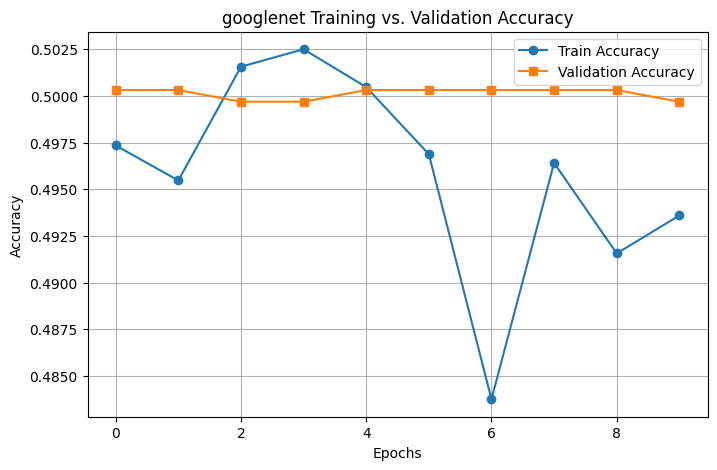

In [7]:
# 🔄 Step 7: Plot Training vs. Validation Accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(googlenet_history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(googlenet_history.history['val_accuracy'], label='Validation Accuracy', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('googlenet Training vs. Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
# 🔄 Step 8: Evaluate the Model on Test Data
test_loss, test_acc = googlenet_model.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.4f}")

64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 215ms/step - accuracy: 0.8330 - loss: 0.6926
Test accuracy: 0.4998


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


<ipython-input-9-e6d009ee7001>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_label = class_labels[int(prediction[0] > 0.5)]  # Binary classification


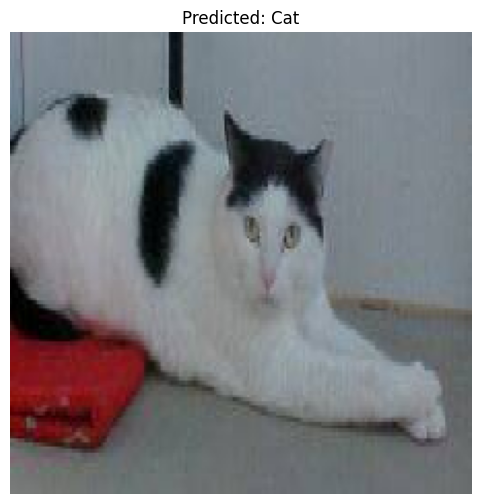

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

def classify_image_alexnet(model, image_path, class_labels=('Cat', 'Dog')):
    # Load and preprocess image
    img = image.load_img(image_path, target_size=(224, 224))  
    img_array = image.img_to_array(img) / 255.0  # Normalize image to 0-1 range
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    
    # Make prediction
    prediction = model.predict(img_array)
    predicted_label = class_labels[int(prediction[0] > 0.5)]  # Binary classification
    
    # Display image with prediction
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicted: {predicted_label}')
    plt.show()

# Example Usage:
image_path = "/kaggle/input/cat-and-dog/test_set/test_set/cats/cat.4022.jpg"  # Change to your image path
classify_image_alexnet(googlenet_model, image_path)  

In [10]:
from tensorflow.keras.optimizers import Adam

# 🔹 Load Pre-trained InceptionV3 model (GoogleNet upgraded)
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 🔥 Step 1: Unfreeze Last Few Layers for Fine-Tuning
for layer in base_model.layers[:-20]:  # Freeze all but last 20 layers
    layer.trainable = False

# 🔥 Step 2: Add Global Average Pooling Instead of Flatten
x = GlobalAveragePooling2D()(base_model.output)  # More efficient than Flatten()

# 🔥 Step 3: Fully Connected Layers with Regularization
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)  # Prevent overfitting
x = Dense(1, activation='sigmoid')(x)  # Binary Classification (Cat/Dog)

# 🔥 Step 4: Create and Compile Model
inv3_model = Model(inputs=base_model.input, outputs=x)
inv3_model.compile(optimizer=Adam(learning_rate=5e-4), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
# 🔄 Step 6: Train the Model
inv3_history = inv3_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    verbose=1
)

Epoch 1/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 124s 512ms/step - accuracy: 0.9510 - loss: 0.1225 - val_accuracy: 0.9788 - val_loss: 0.0607
Epoch 2/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 91s 439ms/step - accuracy: 0.9774 - loss: 0.0583 - val_accuracy: 0.9663 - val_loss: 0.0812
Epoch 3/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 90s 435ms/step - accuracy: 0.9822 - loss: 0.0526 - val_accuracy: 0.9825 - val_loss: 0.0566
Epoch 4/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 90s 435ms/step - accuracy: 0.9821 - loss: 0.0487 - val_accuracy: 0.9756 - val_loss: 0.0565
Epoch 5/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 91s 439ms/step - accuracy: 0.9846 - loss: 0.0405 - val_accuracy: 0.9800 - val_loss: 0.0562
Epoch 6/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 90s 437ms/step - accuracy: 0.9860 - loss: 0.0366 - val_accuracy: 0.9775 - val_loss: 0.0564
Epoch 7/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 91s 441ms/step - accuracy: 0.9849 - loss: 0.0441 - val_accuracy: 0.9825 - val_loss: 0.0422
Epoch 8/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 90s 436ms/step - accuracy: 0.9894 - loss: 

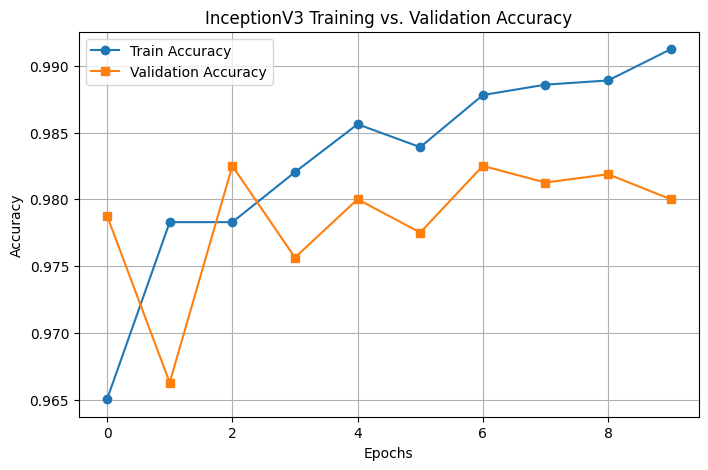

In [12]:

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(inv3_history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(inv3_history.history['val_accuracy'], label='Validation Accuracy', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('InceptionV3 Training vs. Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
# 🔄 Step 8: Evaluate the Model on Test Data
test_loss, test_acc = inv3_model.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.4f}")

64/64 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - accuracy: 0.9920 - loss: 0.0396
Test accuracy: 0.9896


In [14]:
# input_shape = (224, 224, 3)
# base_model = InceptionResNetV2(include_top=False,weights='imagenet',input_shape = input_shape)
# for layer in base_model.layers[:-20]:  # Freeze all but last 20 layers
#     layer.trainable = False
# x = GlobalAveragePooling2D()(base_model.output) 